In [1]:
import os
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

image_dir = "./images"
label_dir = "./labels"

images = glob(os.path.join(image_dir, '*.png'))
labels = glob(os.path.join(label_dir, '*.png'))

In [2]:
tags = {0:None, 
        1:"Buildings", 
        2:"Fences",
        3:"Other",
        4:"Pedestrians",
        5:"Poles",
        6:"RoadLines",
        7:"Roads",
        8:"Sidewalks",
        9:"Vegetation",
        10:"Vehicles",
        11:"Walls",
        12:"TrafficSigns"}

total_images = len(images)
total_labels = len(labels)
print("Total images:", total_images)
print("Total labels:", total_labels)

Total images: 1000
Total labels: 1000


In [3]:
# creating data object
d = {'image':images, 'label':labels}
columns = ['image', 'label']
data = pd.DataFrame(d, columns=columns)

Since the training dataset contains hood pixels, we have to get rid of them. 
But the test dataset with same resilution will not contain hood pixels.
My solution is:
- crop the images in test dataset by cutting 100 bottom pixels 
- resize the obtained image so the dimentions can be scaled to the initial size (i.e. since the height loses 100 pixels it becomes 5/6 of the initial number. So the width must become 800*5/6 = 666)
- during training perform scaling and shifting augmentation.  

In [60]:
# getting rid of the bottom pixels and resize images and labels.

def get_image_and_labels(sample, shape=(256,128)):
    image = cv2.imread(sample['image'])
    label = cv2.imread(sample['label'])[:,:,2]
    image = image[155:555,:,:]
    label = label[155:555,:]
    
    # get label for road pixels (road and lane lines must be the same label)
    label[label == 6] = 7
    label_road = np.zeros_like(label)
    label_road[label == 7] = 1
    
    # get label for car pixels
    label_car = np.zeros_like(label)
    
    label_car_bot = np.zeros_like
    label_car[label == 10] = 1
    
    vehicle_pixels = (label == 10).nonzero()
    # Isolate vehicle pixels associated with the hood (y-position > 496)
    hood_indices = (vehicle_pixels[0] >= 335).nonzero()[0]
    hood_pixels = (vehicle_pixels[0][hood_indices], \
                   vehicle_pixels[1][hood_indices])
    # Set hood pixel labels to 0
    label_car[hood_pixels] = 0
    
    
    # resizing
    image = cv2.resize(image, shape, interpolation = cv2.INTER_NEAREST)
    label_car = cv2.resize(label_car, shape, interpolation = cv2.INTER_NEAREST)
    label_road = cv2.resize(label_road, shape, interpolation = cv2.INTER_NEAREST)
    return image, label_car, label_road

def get_real_labels(sample):
    label = cv2.imread(sample['label'])[:,:,2]
    label[label == 6] = 7
    label_road = np.zeros_like(label)
    label_road[label == 7] = 1
    label_car = np.zeros_like(label)
    label_car[label == 10] = 1
    return label_car, label_road

Let's see if we aren't losing anything after applying the transformations.

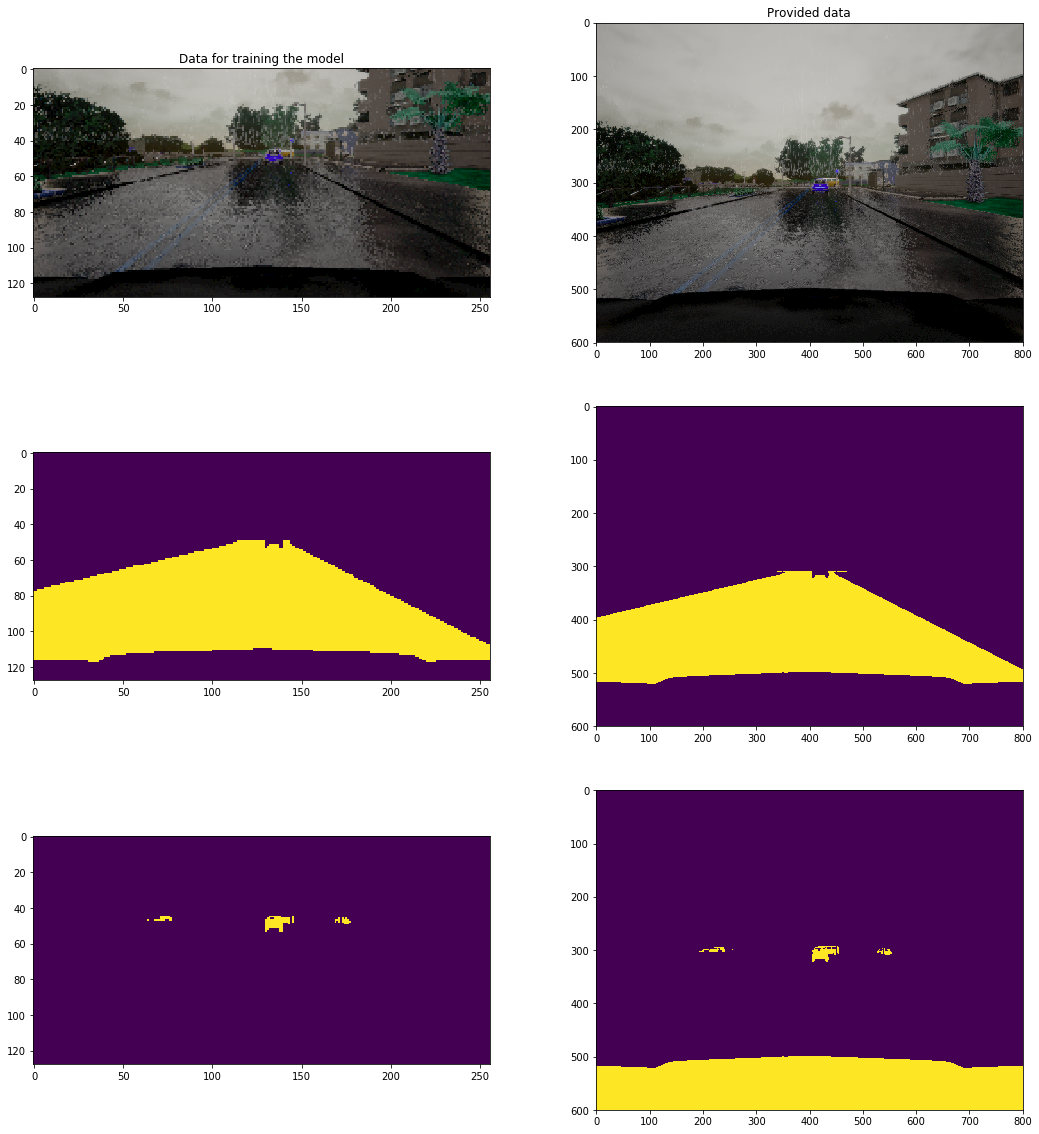

In [61]:
sample = data.iloc[213]
dataset_image = cv2.imread(sample['image'])
train_image, label_car, label_road = get_image_and_labels(sample)

lb_car, lb_road = get_real_labels(sample)

fig, axarr = plt.subplots(3,2,figsize = (18,20))

axarr[0,0].set_title('Data for training the model')
axarr[0,0].imshow(train_image)
axarr[0,1].set_title('Provided data')
axarr[0,1].imshow(dataset_image)

axarr[1,0].imshow(label_road)
axarr[1,1].imshow(lb_road)

axarr[2,0].imshow(label_car)
axarr[2,1].imshow(lb_car)

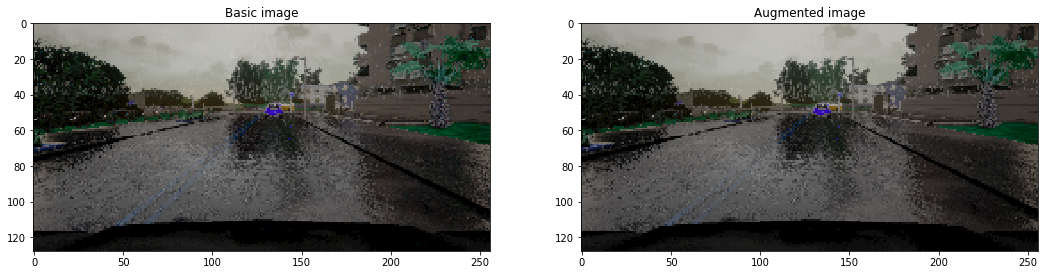

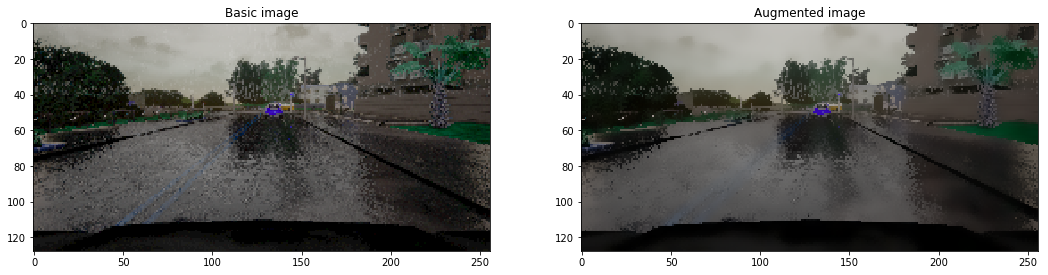

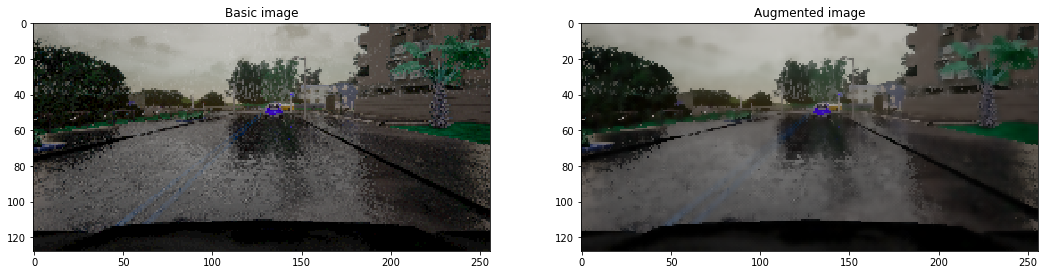

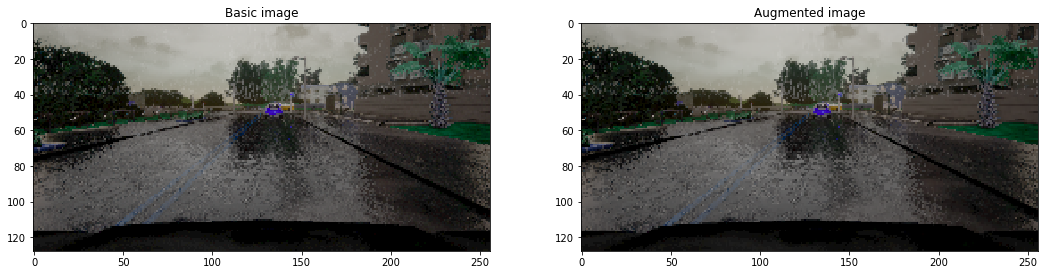

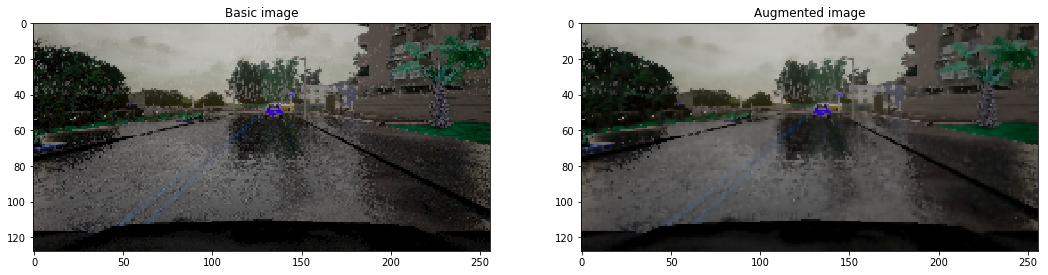

In [62]:
def bilateral_blur(img):
    kernel = np.random.randint(75)
    mul = np.random.randint(10)
    blur = cv2.bilateralFilter(img,mul,kernel,kernel)
    return blur

for i in range(5):
    fig,axarr = plt.subplots(1,2, figsize=(18,8))
    bilateral_image = bilateral_blur(train_image)
    axarr[0].set_title('Basic image')
    axarr[0].imshow(train_image)
    axarr[1].set_title('Augmented image')
    axarr[1].imshow(bilateral_image)


Gaussian blur

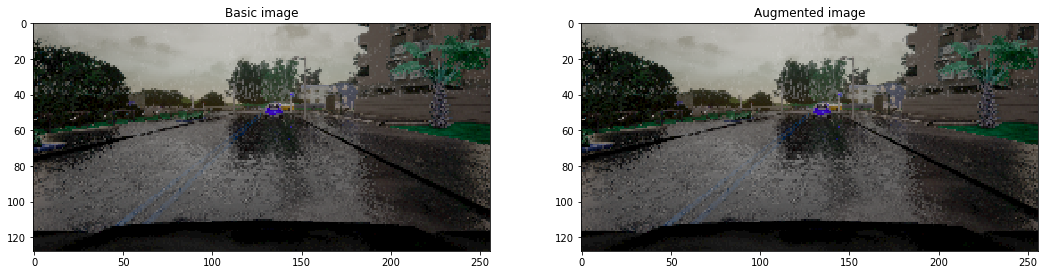

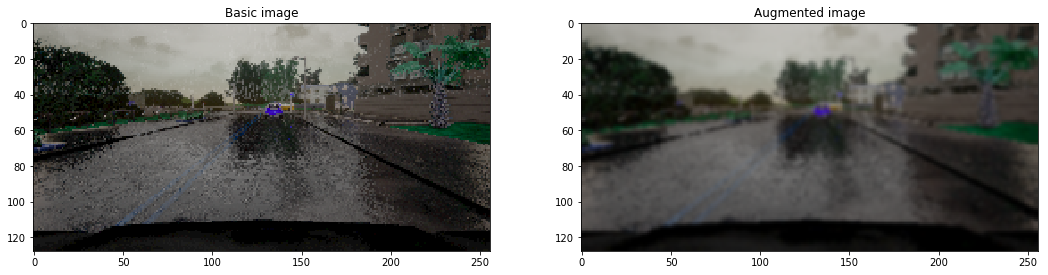

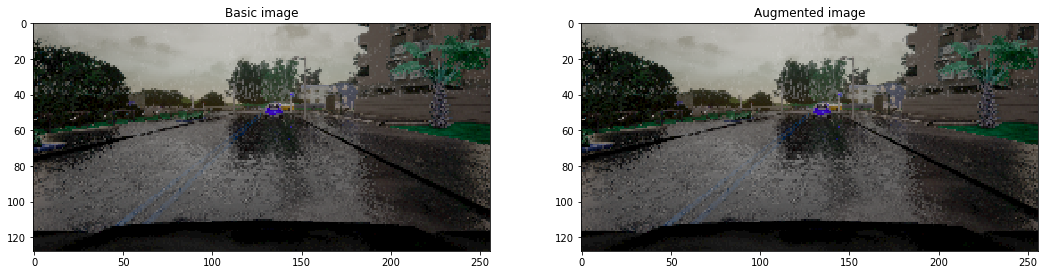

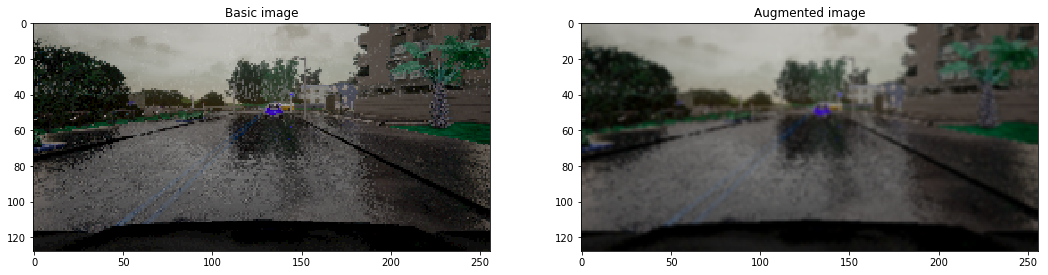

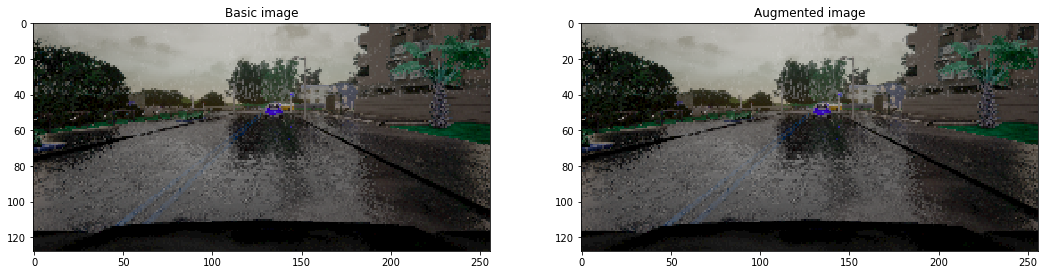

In [63]:
def gaussian_blur(img):
    filters = [1,3,5]
    kernel = np.random.choice(filters, p=[.5,.3,.2])
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

for i in range(5):
    fig,axarr = plt.subplots(1,2, figsize=(18,8))
    gausian_image = gaussian_blur(train_image)
    axarr[0].set_title('Basic image')
    axarr[0].imshow(train_image)
    axarr[1].set_title('Augmented image')
    axarr[1].imshow(gausian_image)

Brightness

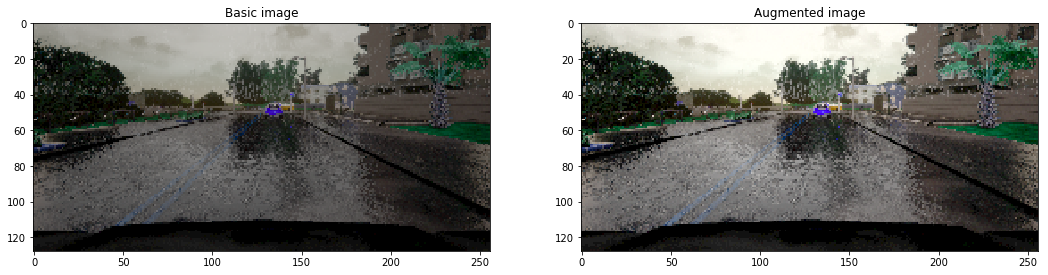

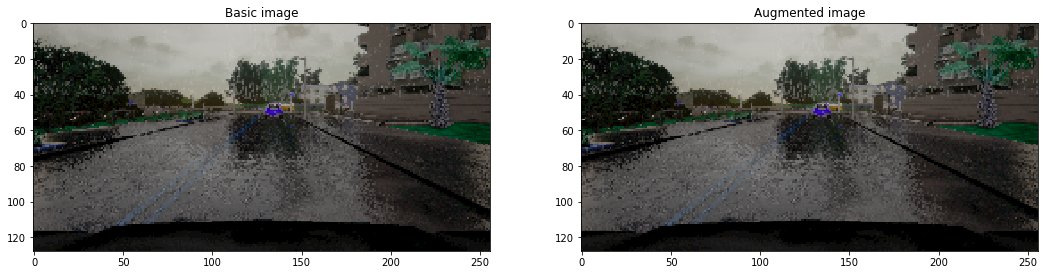

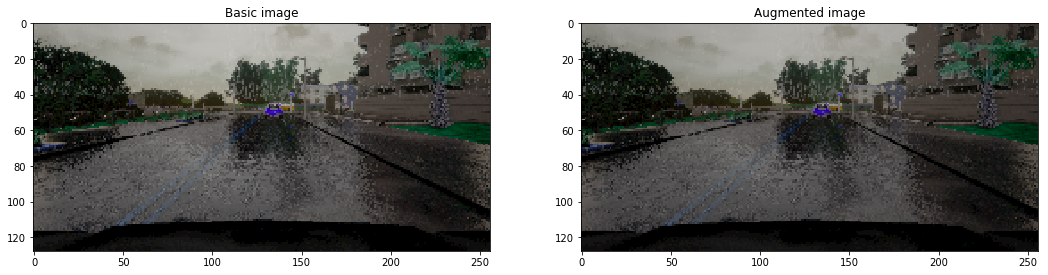

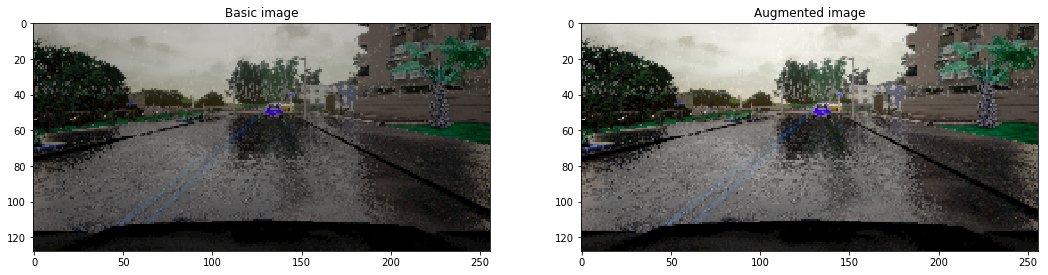

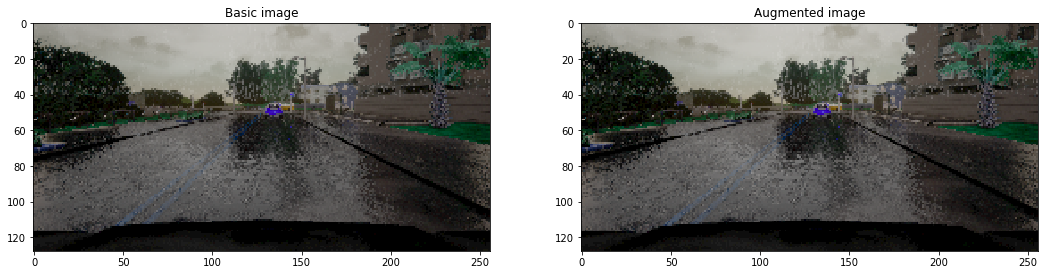

In [64]:
def augment_brightness(image):
    img_aug = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    img_aug = np.array(img_aug, dtype = np.float64)
    
    random_bright = .5+np.random.uniform()
    #random_bright = .5+np.random.uniform()
    #random_bright = .5+np.random.uniform()
    
    img_aug[:,:,2] = img_aug[:,:,2]*random_bright
    img_aug[:,:,2][img_aug[:,:,2]>255]  = 255
    
    img_aug = np.array(img_aug, dtype = np.uint8)
    img_aug = cv2.cvtColor(img_aug,cv2.COLOR_HSV2RGB)
    return img_aug

for i in range(5):
    fig,axarr = plt.subplots(1,2, figsize=(18,8))
    bright_image = augment_brightness(train_image)
    axarr[0].set_title('Basic image')
    axarr[0].imshow(train_image)
    axarr[1].set_title('Augmented image')
    axarr[1].imshow(bright_image)

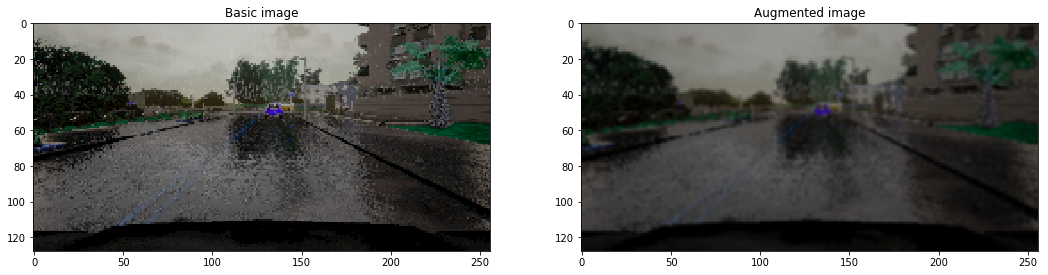

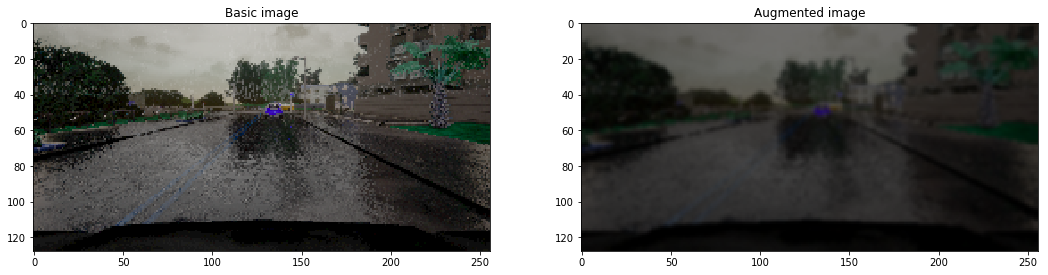

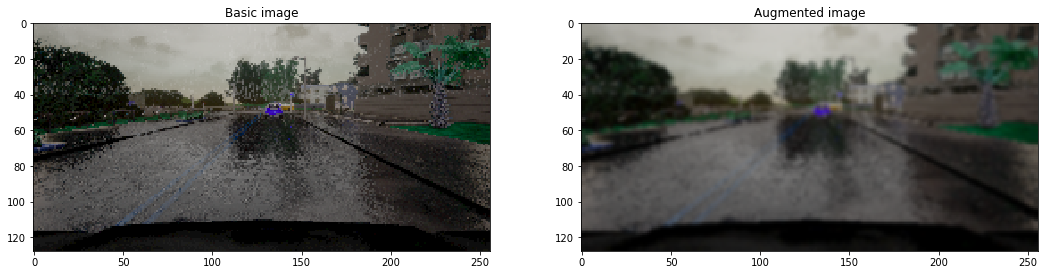

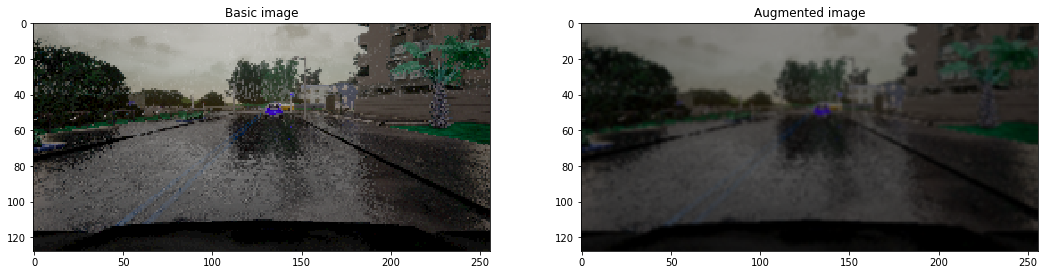

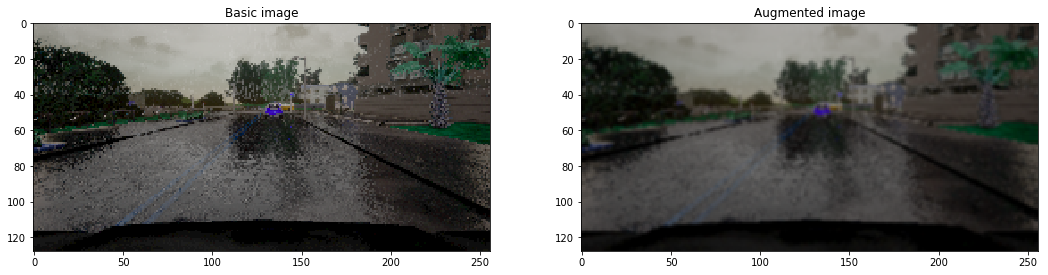

In [65]:
for i in range(5):
    fig,axarr = plt.subplots(1,2, figsize=(18,8))
    
    bright_image = augment_brightness(gaussian_blur(train_image))
    axarr[0].set_title('Basic image')
    axarr[0].imshow(train_image)
    axarr[1].set_title('Augmented image')
    axarr[1].imshow(bright_image)

Adding salt and pepper

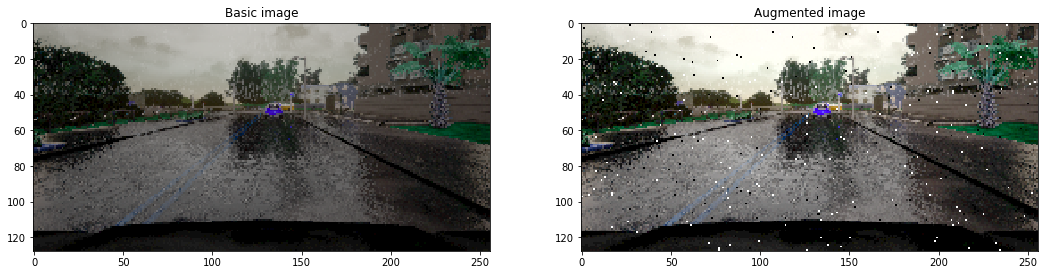

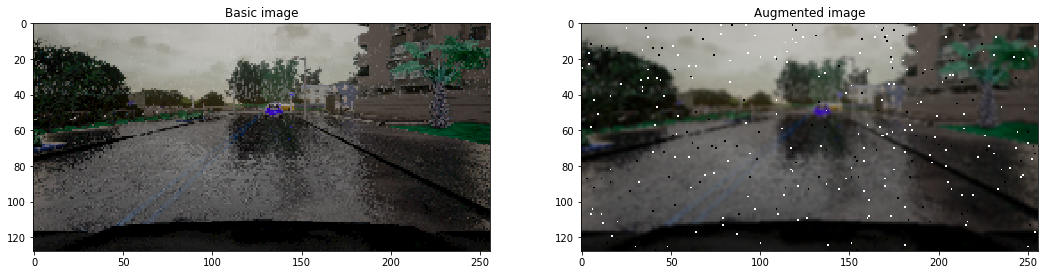

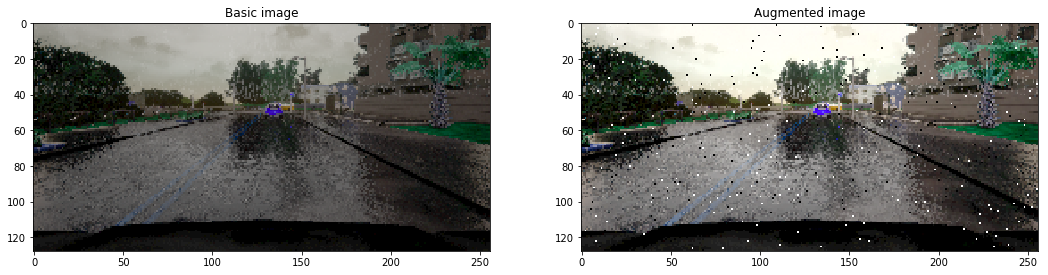

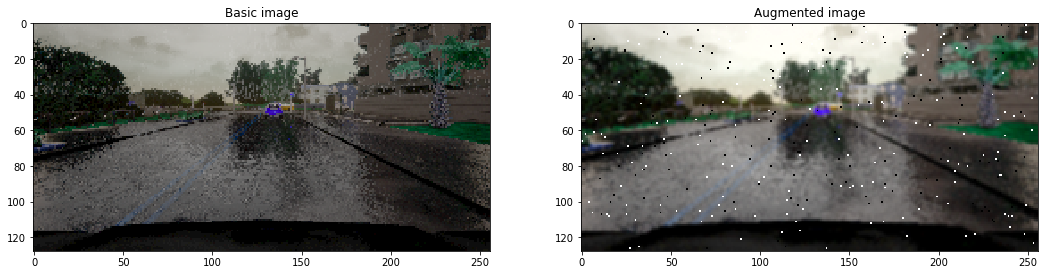

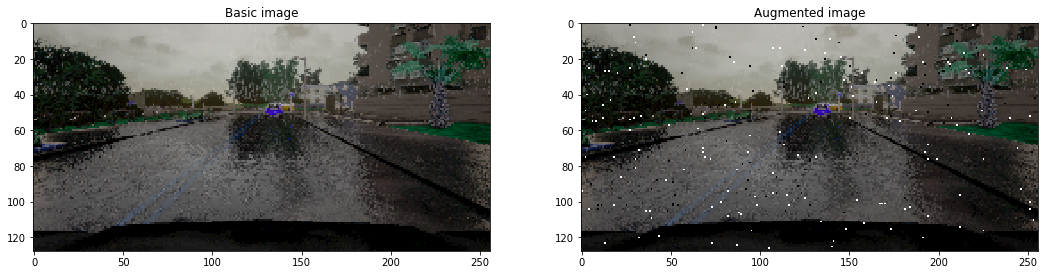

In [66]:
def to_std_uint8(img):
    # Properly handles the conversion to uint8
    img = cv2.convertScaleAbs(img, alpha = (255/1))

    return img

def to_std_float(img):
    #Converts img to 0 to 1 float to avoid wrapping that occurs with uint8
    img.astype(np.float16, copy = False)
    img = np.multiply(img, (1/255))

    return img
def salt_n_pepper(img, pad = 200, show = 1):
    # Convert img1 to 0 to 1 float to avoid wrapping that occurs with uint8
    img = to_std_float(img)

    # Generate noise to be added to the image. We are interested in occurrences of high
    # and low bounds of pad. Increased pad size lowers occurence of high and low bounds.
    # These high and low bounds are converted to salt and pepper noise later in the
    # function. randint is inclusive of low bound and exclusive of high bound.
    noise = np.random.randint(pad, size = (img.shape[0], img.shape[1], 1))

    # Convert high and low bounds of pad in noise to salt and pepper noise then add it to
    # our image. 1 is subtracted from pad to match bounds behaviour of np.random.randint.
    img = np.where(noise == 0, 0, img)
    img = np.where(noise == (pad-1), 1, img)

    # Properly handles the conversion from float16 back to uint8
    img = to_std_uint8(img)
    return img

for i in range(5):
    fig,axarr = plt.subplots(1,2, figsize=(18,8))
    blur_ = np.random.random()
    if(blur_ > 0.5):
        aug_image = salt_n_pepper(augment_brightness(gaussian_blur(train_image)))
    else:
        aug_image = salt_n_pepper(augment_brightness(bilateral_blur(train_image)))
    axarr[0].set_title('Basic image')
    axarr[0].imshow(train_image)
    axarr[1].set_title('Augmented image')
    axarr[1].imshow(aug_image)

Random zooming and shifting (not sure if it will improve training, but have to try)

Augmentation results:


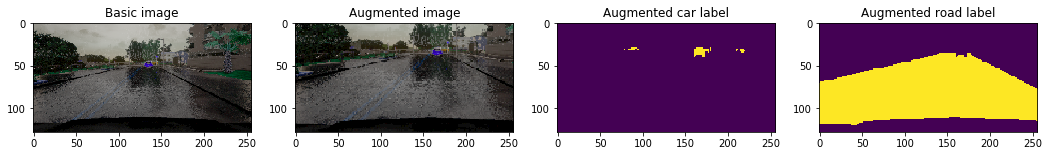

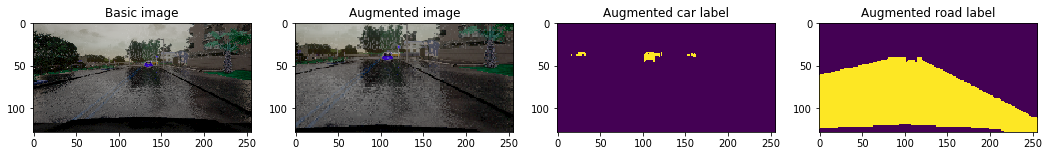

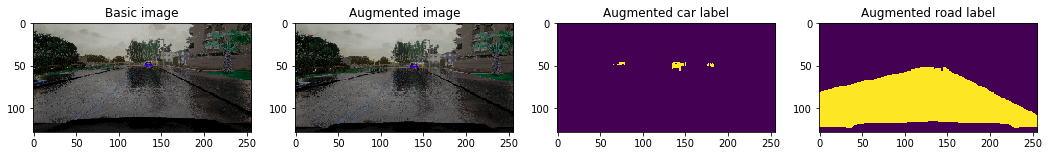

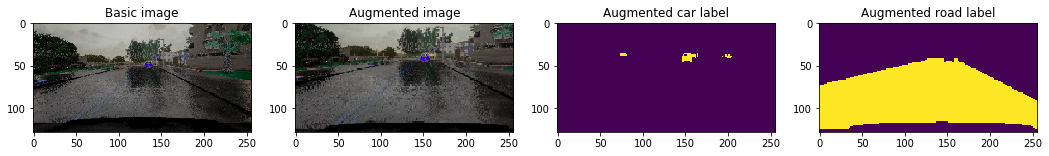

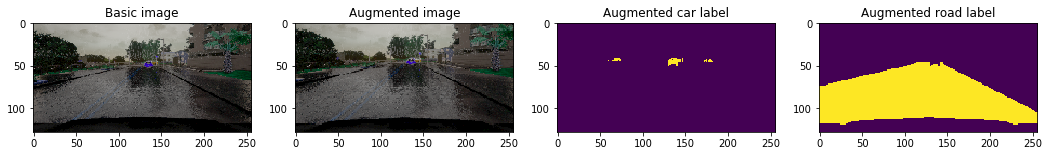

In [67]:
def get_zoomed_images_labels(img, car_label, road_label, scale=0.5):
    
    basic_width = img.shape[1]
    basic_height = img.shape[0]

    scale = scale * np.random.random()
    res_scale = 1 + scale
    zoomed_img = cv2.resize(img,None,fx=res_scale, fy=res_scale, interpolation = cv2.INTER_NEAREST)
    zoomed_car = cv2.resize(car_label,None,fx=res_scale, fy=res_scale, interpolation = cv2.INTER_NEAREST)
    zoomed_road = cv2.resize(road_label,None,fx=res_scale, fy=res_scale, interpolation = cv2.INTER_NEAREST)
    
    # We've got a resized image and labels. Now for the random shifting we need to slice 
    # the area of initial size starting from random position.
    # Since we shall use only 20-30% zoom, we can start from any random position
    # i.e y_start can be all the way from 0 to (zoomed_height - basic_height)
    # and x_start can be all the way from 0 to (zoomed_width - basic_width)

    max_y_start = int(basic_height * scale) 
    max_x_start = int(basic_width * scale)
    
    # random start for x:
    x_rand = np.random.random()
    x_start = int(max_x_start * x_rand)
    
    # random start for y:
    y_rand = np.random.random()
    y_start = int(max_y_start * y_rand)
    
    # now slice the zoomed images:
    zoomed_img = zoomed_img[y_start:y_start+basic_height, x_start:x_start+basic_width]
    zoomed_car = zoomed_car[y_start:y_start+basic_height, x_start:x_start+basic_width]
    zoomed_road = zoomed_road[y_start:y_start+basic_height, x_start:x_start+basic_width]
    
    return zoomed_img, zoomed_car, zoomed_road

print('Augmentation results:')
for i in range(5):
    fig,axarr = plt.subplots(1,4, figsize=(18,6))
    zoomed_image, car_label, road_label = get_zoomed_images_labels(train_image, label_car, label_road)
    axarr[0].set_title('Basic image')
    axarr[0].imshow(train_image)
    axarr[1].set_title('Augmented image')
    axarr[1].imshow(zoomed_image)
    axarr[2].set_title('Augmented car label')
    axarr[2].imshow(car_label)
    axarr[3].set_title('Augmented road label')
    axarr[3].imshow(road_label)

Define training/validation generator:

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Sequential
from keras import initializers
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten, Lambda, Conv2D, MaxPooling2D, Cropping2D, Dropout, BatchNormalization, Conv2DTranspose

# split training and validation data

# I use only 1% of data for testing, actually I only want to visualize the results on few unseen images. 
# Since the test dataset will be different anyway, and the given dataset is not large enough,
# I just want to train the model on more samples and then just look at some new images, so 1% is enough.
# The validation size is still matters so I kept it close to 20%

train_samples, validation_data = train_test_split(data, test_size=0.2) # 80% train, 20% the rest
validation_samples, test_samples = train_test_split(validation_data, test_size=0.05) # 19% validation, 1% test
train_samples = data

im_height = 128
im_width = 256

# define the generator
def generator(samples, batch_size = 32):
    num_samples = len(samples)
    while 1:
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            labels = []
            for ind, sample in batch_samples.iterrows():
                image, lb_car, lb_road = get_image_and_labels(sample)
                
                # apply gaussian or bilateral blur:
                blur_prob = np.random.random()
                if(blur_prob>0.5):
                    image = gaussian_blur(image)
                else:
                    image = bilateral_blur(image)
                
                # brightness augmentation:
                image = augment_brightness(image)
                
                # forming labels
                final_label = np.zeros((im_height,im_width,2))
                final_label[:,:,1] = lb_road
                final_label[:,:,0] = lb_car
                final_label = final_label.reshape(im_height*im_width*2,)
                
                # with 50% chance augment the image.
                is_aug = np.random.random()
                if(is_aug > 0.5):                 # 50% chance to augment geometry
                    zoomed_image, zoomed_car, zoomed_road = get_zoomed_images_labels(image, lb_car, lb_road)
                    zoomed_label = np.zeros((im_height,im_width,2))
                    zoomed_label[:,:,1] = zoomed_road
                    zoomed_label[:,:,0] = zoomed_car
                    zoomed_label = zoomed_label.reshape(im_height*im_width*2,)
                    image = zoomed_image
                    final_label = zoomed_label
                images.append(image)
                labels.append(final_label)
                    
                image, final_label, zoomed_image, zoomed_label=None,None,None,None
                lb_car, lb_road, zoomed_car, zoomed_road = None,None,None,None
                
            X_train = np.array(images)
            y_train = np.array(labels)
            images, labels = None, None
            yield shuffle(X_train, y_train)

# define batch size and create the generators
batch_size = 16
train_generator = generator(train_samples, batch_size)
validation_generator = generator(validation_samples, batch_size)

In [69]:
from keras import models
from keras.layers.core import Activation, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D,Cropping2D
from keras.layers.normalization import BatchNormalization
import json

img_w = im_width
img_h = im_height
n_labels = 2

kernel = 3
drop_rate = 0.2

encoding_layers = [
    Lambda(lambda x: x / 255.0 - 0.5, input_shape = (img_h, img_w, 3)),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),#, input_shape=( img_h, img_w,3)),
    BatchNormalization(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(drop_rate),

    Conv2D(128, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(128, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(drop_rate),

    Conv2D(256, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(256, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(256, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(drop_rate),

    Conv2D(512, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(512, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(512, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(drop_rate),
    
    Conv2D(512, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(512, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(512, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(drop_rate),

]

model = models.Sequential()
model.encoding_layers = encoding_layers
for l in model.encoding_layers:
    model.add(l)

decoding_layers = [
    
    UpSampling2D(),
    Conv2D(512, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(512, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(512, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    
    UpSampling2D(),
    Conv2D(512, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(512, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(512, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),

    UpSampling2D(),
    Conv2D(256, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(256, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(128, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),

    UpSampling2D(),
    Conv2D(128, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),

    UpSampling2D(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(n_labels, 1, padding='valid'),
    BatchNormalization(),
    Flatten(),
    Activation('sigmoid')
    
]
model.decoding_layers = decoding_layers
for l in model.decoding_layers:
#for l in decoding_layers:
    model.add(l)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_11 (Lambda)           (None, 128, 256, 3)       0         
_________________________________________________________________
conv2d_213 (Conv2D)          (None, 128, 256, 64)      1792      
_________________________________________________________________
batch_normalization_213 (Bat (None, 128, 256, 64)      256       
_________________________________________________________________
conv2d_214 (Conv2D)          (None, 128, 256, 64)      36928     
_________________________________________________________________
batch_normalization_214 (Bat (None, 128, 256, 64)      256       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 64, 128, 64)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 128, 64)       0         
__________

In [73]:
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.optimizers import Adam

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=0, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
optimizer = Adam(lr=0.001, beta_1=0.7, beta_2=0.85)

model.compile(loss = 'binary_crossentropy', optimizer = optimizer)

stats = model.fit_generator(train_generator, steps_per_epoch= len(train_samples)/batch_size, 
                            validation_data=validation_generator, validation_steps=len(validation_samples)/batch_size, 
                            epochs=500), callbacks=[reduce_lr, early_stop])


Epoch 1/500


ResourceExhaustedError: OOM when allocating tensor with shape[16,64,128,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_237/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](up_sampling2d_47/ResizeNearestNeighbor, PermConstNHWCToNCHW-LayoutOptimizer)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: flatten_11/Shape/_17783 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_3239_flatten_11/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
print(stats.history.keys())
plt.plot(stats.history['loss'])
plt.plot(stats.history['val_loss'])


Well I could train it for ~100 epochs with precisely same results.

In [17]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("model_new.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_new.h5")
print("Saved model to disc")
 

Saved model to disc


In [ ]:
model.fit_generator(train_generator, steps_per_epoch= len(train_samples)/batch_size, validation_data=validation_generator, validation_steps=len(validation_samples)/batch_size, epochs=50)
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("model_new1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_new1.h5")
print("Saved model to disc")
 

In [95]:
from keras.models import model_from_json
# load json and create model
json_file = open('model_augmentation.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_augmentation.h5")
print("Loaded model from disc")

Loaded model from disc


Visualize some predictions:

In [108]:
def get_predictions(model, img):
    img = img[100:500,:,:]
    img = cv2.resize(img, (200,88))#, interpolation = cv2.INTER_NEAREST)
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = pred[0]
    pred = pred.reshape(88,200,2)
    car_pred = pred[:,:,0]
    road_pred = pred[:,:,1]
    
    car_pred_ = np.zeros(car_pred.shape)
    car_pred_[car_pred>0.3] = 1
    
    road_pred_ = np.zeros(road_pred.shape)
    road_pred_[road_pred>0.3] = 1
    
    car_pred_final = np.zeros((600,800))
    road_pred_final = np.zeros((600,800))
    
    car_pred_ = cv2.resize(car_pred_, (800,400), interpolation = cv2.INTER_NEAREST)
    road_pred_ = cv2.resize(road_pred_, (800,400), interpolation = cv2.INTER_NEAREST)
    car_pred_final[100:500,:] = car_pred_
    road_pred_final[100:500,:] = road_pred_
    
    return car_pred_final, road_pred_final

In [109]:
from sklearn.metrics import accuracy_score

def plot_results(img, lbl, car_pred, road_pred):
    fig, axarr = plt.subplots(2,3,figsize=(20,8))
    for ax in axarr:
        for subax in ax:
            subax.axis('off')
# first lane contains image and labels for car and road pixels
    axarr[0,0].set_title('Original image')
    axarr[0,0].imshow(img)
    
    lbl_car = np.zeros(lbl.shape)
    lbl_car[lbl == 10] = 1
    axarr[0,1].set_title('Car label')
    axarr[0,1].imshow(lbl_car)
    
    lbl_road = np.zeros(lbl.shape)
    lbl_road[lbl == 7] = 1
    lbl_road[lbl == 6] = 1
    axarr[0,2].set_title('Road label')
    axarr[0,2].imshow(lbl_road)

# second lane contains image and predictions for car and road pixels + accuracies
    axarr[1,0].imshow(img)
    
    car_acc = accuracy_score(car_pred, lbl_car)
    axarr[1,1].set_title('Car pred, accuracy={0}'.format(car_acc))
    axarr[1,1].imshow(car_pred)
    
    road_acc = accuracy_score(road_pred, lbl_road)
    axarr[1,2].set_title('Road pred, accuracy={0}'.format(road_acc))
    axarr[1,2].imshow(road_pred)

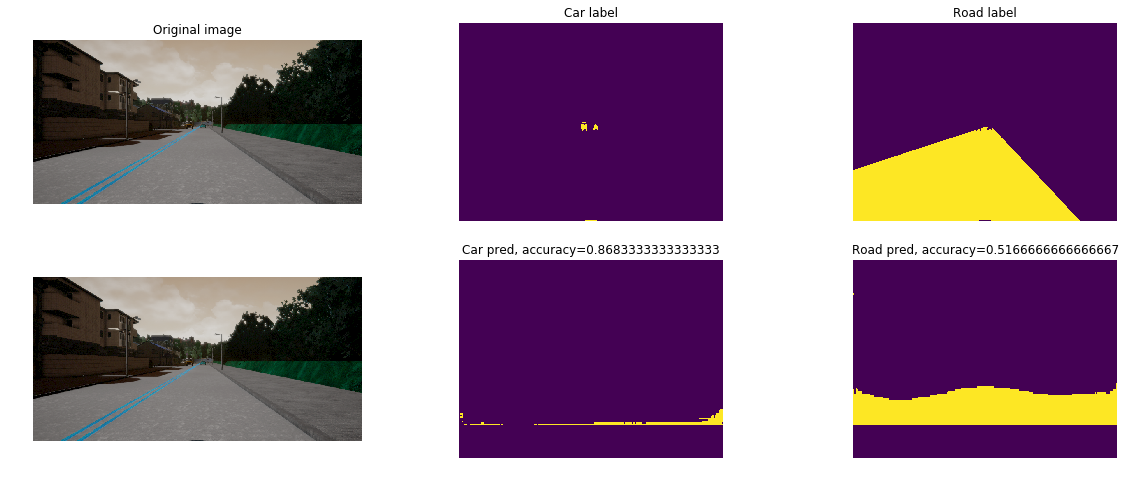

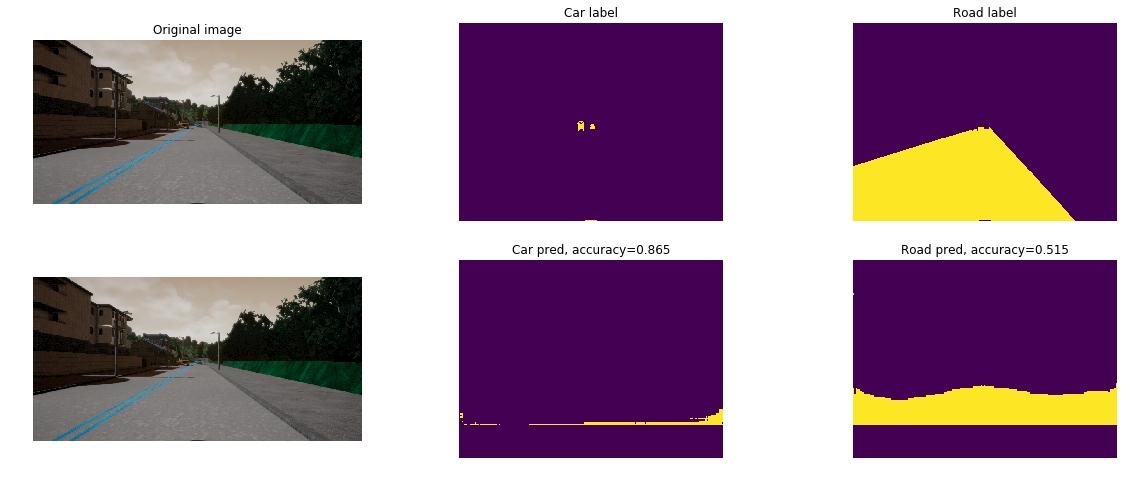

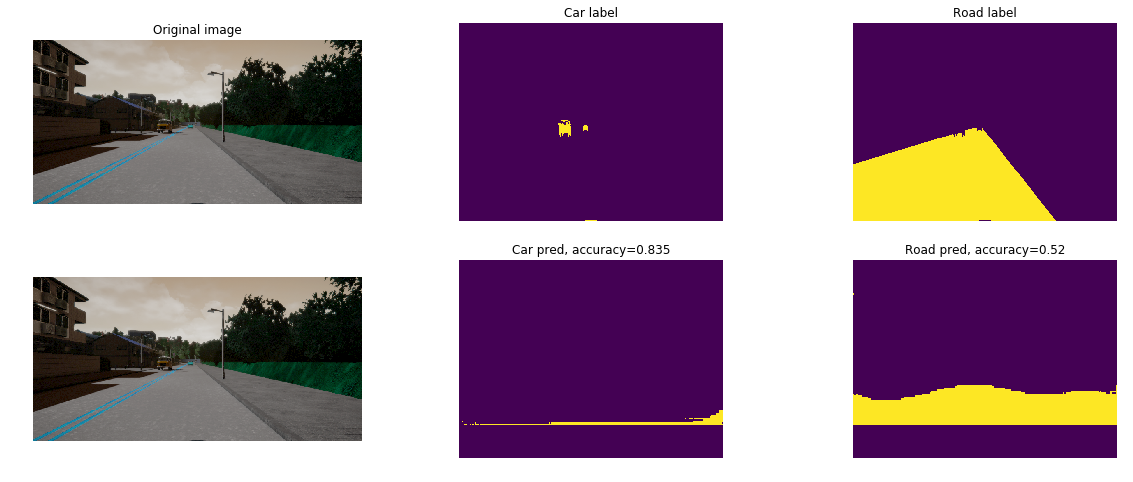

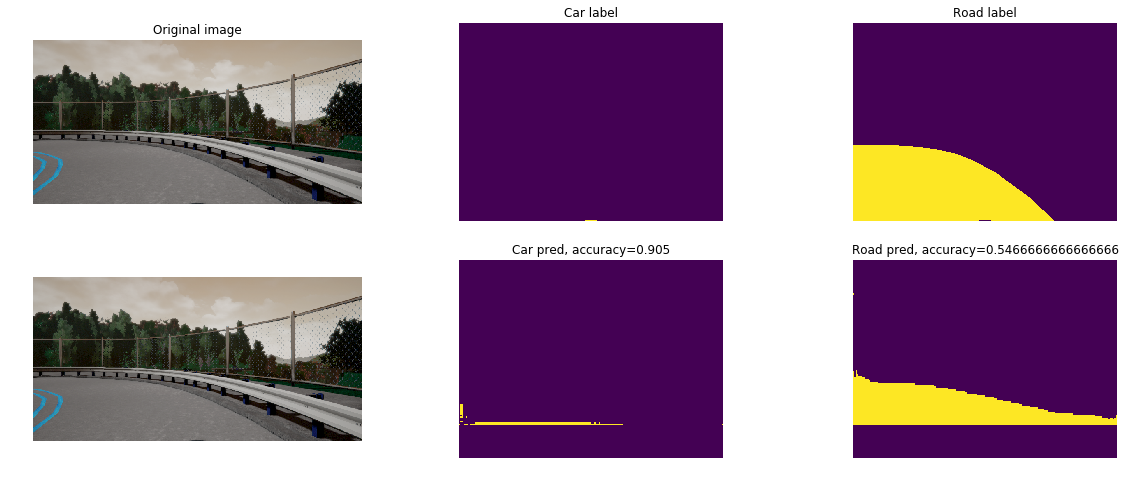

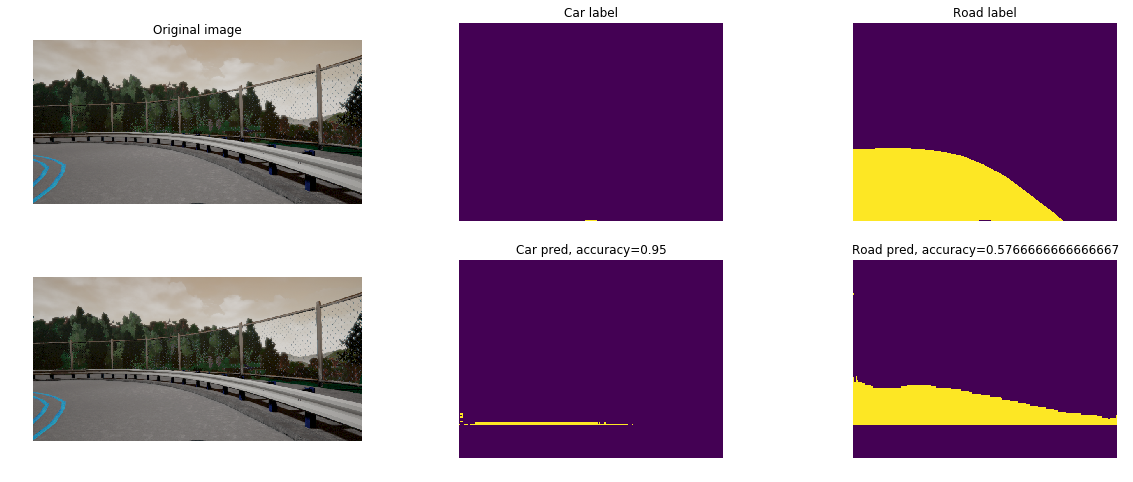

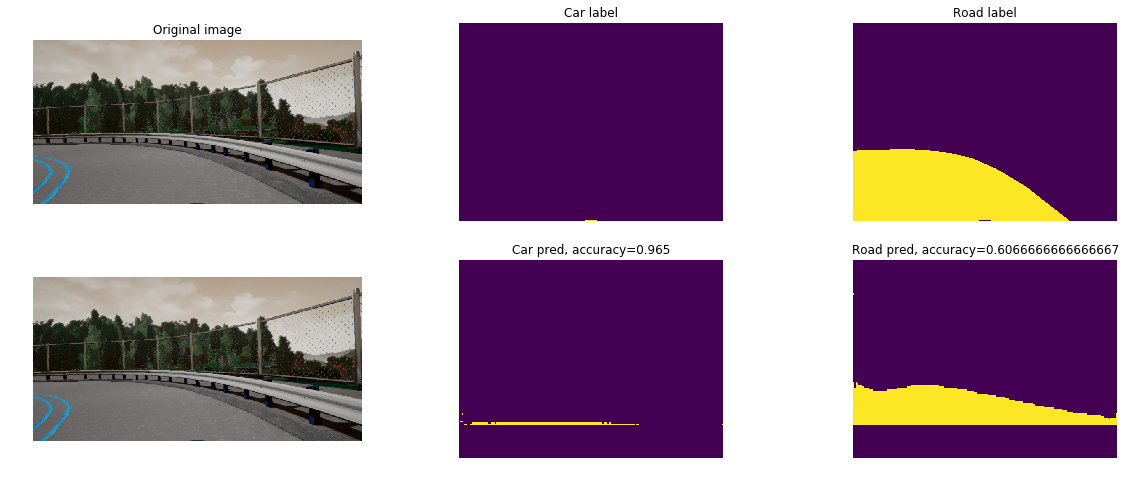

In [111]:
for i in range(len(test_samples)):
    test_img  = cv2.imread(data.iloc[i]['image'])
    test_img = test_img[100:500,:,:]
    test_lbl  = cv2.imread(data.iloc[i]['label'])[:,:,2]
    test_lbl = test_lbl[100:500,:]
    test_lbl = cv2.resize(test_lbl, (800,600), interpolation = cv2.INTER_NEAREST )
    car_pred, road_pred = get_predictions(loaded_model, test_img)
    plot_results(test_img, test_lbl, car_pred, road_pred)

51~ ms. Since my GPU is roughly equal to Tesla K80, this must run at 20~ FPS.